# Taxi Demand Prediction - New York City

## Business/Real World Problem
For a given location in New York City, our goal is to <b>predict the number of pickups in that given location</b>. Some location require more taxis at a particular time than other locations owing to the presence schools, hospitals, offices etc. The prediction result can be transferred to the taxi drivers via Smartphone app, and they can subsequently move to the locations where predicted pickups are high.

## Information on Taxis

<b>Information on taxis:</b><br>
* <b>Yellow Taxi:</b> Yellow Medallion Taxicabs<br>
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.<br><br>
* <b>For Hire Vehicles (FHVs)</b><br> 
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.<br><br>
* <b>Green Taxi: Street Hail Livery (SHL)</b><br> 
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.<br><br>
<b>In this project we are considering only the yellow taxis for the time period of Jan 2015. We have used Jan- 2015 data to make prediction for Jan- 2016 data.</b>

In [1]:
# !pip install -q gpxpy
# !pip install -q sklearn

In [2]:
# !pip install -q sklearn

In [3]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans


# from numba import jit, cuda 

import warnings
warnings.simplefilter('ignore')

In [4]:
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv


In [5]:
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv

In [6]:
!ls

ML_Project_3.ipynb		  yellow_tripdata_2015-01.csv
README.md			  yellow_tripdata_2016-01.csv
Taxi_Demand_Prediction_NYC.ipynb


In [7]:
data_2015 = dd.read_csv("yellow_tripdata_2015-01.csv")
# data_2015 = pd.read_csv("yellow_tripdata_2015-01.csv")

In [8]:
data_2015.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [9]:
data_2015.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [10]:
print("Number of columns = "+str(len(data_2015.columns)))

Number of columns = 19


In [11]:
# data_2015.visualize()

In [12]:
data_2015["passenger_count"].sum()
# data_2015["passenger_count"].sum().visualize()

dd.Scalar<series-..., dtype=int64>

In [13]:
print("Total Number of Passengers in January 2015 = "+str(data_2015["passenger_count"].sum(axis = 0).compute()))
# print("Total Number of Passengers in January 2015 = "+str(data_2015["passenger_count"].sum(axis = 0))) #for pd instead of dd

Total Number of Passengers in January 2015 = 21437303


In [14]:
print("Number of nan values = {}".format(data_2015.isnull().sum().compute()))
# print("Number of nan values = {}".format(data_2015.isnull().sum())) #for pd instead of dd

Number of nan values = VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64


Since we will not be using "improvement_surcharge" in our task, so nan values will not affect us. So, we are leaving it as it is.

### Pickup 

In [15]:
# #detecting the pickups latitude and longitudes which are outside NYC.
# outside_NYC = data_2015[((data_2015.pickup_latitude <= 40.5774) | (data_2015.pickup_longitude <= -74.15) | (data_2015.pickup_latitude >= 40.9176) | (data_2015.pickup_longitude >= -73.7004))]
# #latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
# #is negative and becomes -90 at south pole.
# #Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
# #and is negative.

# m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

# outside_pickups = outside_NYC.head(25000)

# for i,j in outside_pickups.iterrows():
#     if j["pickup_latitude"] != 0:
#         folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
# m

<b>Observation:</b>As you can see in the above map, there are many erroneous data points, which are in some other state, and some of them are even in Atlantic Ocean. All these erroneous data points will also be removed as a part of data cleaning process.

### Dropoff

In [16]:
# #detecting the dropoff latitude and longitudes which are outside NYC.
# outside_NYC = data_2015[((data_2015.dropoff_latitude <= 40.5774) | (data_2015.dropoff_longitude <= -74.15) | (data_2015.dropoff_latitude >= 40.9176) | (data_2015.dropoff_longitude >= -73.7004))]
# #latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
# #is negative and becomes -90 at south pole.
# #Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
# #and is negative.

# m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

# outside_dropoff = outside_NYC.head(25000)

# for i,j in outside_dropoff.iterrows():
#     if j["dropoff_latitude"] != 0:
#         folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
# m
# #documentation of folium: https://python-visualization.github.io/folium/docs-v0.6.0/quickstart.html#Getting-Started

<b>Observation:</b>As you can see in the above map, there are many erroneous data points, which are in some other state, and some of them are even in Atlantic Ocean. All these erroneous data points will also be removed as a part of data cleaning process.

### Creating new Dataframe with Trip duration and speed

In [17]:
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600  #this will convert structured time into unix-time.
    #Now why, I have added 3600 in the above unix times. NOW, UNIX TIMESTAMP MEANS HOW MANY SECONDS HAVE ELAPSED SINCE 1 JAN 1970
    #(EPOCH) CALCULATED FROM THE REFERENCE OF GMT. I HAVE MADE THIS PROJECT IN GERMANY WHICH IS 1HR/3600SECS AHEAD OF GMT TIME, 
    #AND HERE "time.mktime()" FUNCTION RETURNS UNIX TIMESTAMP FROM THE REFERENCE OF LOCAL TIME. SO, THEREFORE, IN ORDER TO 
    #COMPENSATE FOR 1HR AHEAD, "time.mktime" SUBTRACTED 3600 SECONDS MEANS 1HR FROM UNIX TIME STAMP IN ORDER TO CATER TO 
    #LOCAL TIME. SO, THEREFORE, IF WE WANT OUR UNIX TIME TO BE EXACTLY EQUAL TO GMT TIME, WE HAVE TO ADD 3600 SECONDS 
    #MEANS 1HR TO UNIX TIME. lET SAY AT 12:00AM ON 1st JAN 1970, TIME ELAPSED AT GMT IS 0, THE TIME ELAPSED IN GERMANY IS 
    #3600SEC. NOW ON 1st JAN 2015, ELASPED SECONDS AT GMT IS 'X', SO THE EQUIVALENT ELAPSED SECONDS IN GERMANY WILL BE X+3600. 
    #NOW "time.mktime()" SUBTRACT THIS 3600 EXTRA IN GERMAN TIME WHICH WE HAVE TO ADD IN ORDER TO MAKE IT EQUAL TO GMT.

def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    #duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]] #for pd instead of dd

    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
#     trip_duration = []
#     for xy in zip(dropoff_time, pickup_time):
#         trip_duration.append(xy[0] - xy[1])
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
#     NewFrame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']] #for pd instead of dd
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [18]:
new_frame = dfWithTripTimes(data_2015)

Time taken for creation of dataframe is 0:04:50.114900


## Trip Durations

### According to NYC Taxi and Limousine Commission regulations, the maximum allowed trip duration in a 24hrs interval is 12 hrs.

In [19]:
# plt.figure(figsize = (10,6))
# sns.boxplot("trip_duration", data = new_frame, orient = "v")
# plt.tick_params(labelsize = 20)
# plt.ylabel("Trip Duration(minutes)", fontsize = 20)
# plt.show()

In [20]:
quantile_tripDuration = new_frame.trip_duration.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [21]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

0th percentile value of Trip Duration is -1211.0166666666667min
10th percentile value of Trip Duration is 3.8333333333333335min
20th percentile value of Trip Duration is 5.383333333333334min
30th percentile value of Trip Duration is 6.816666666666666min
40th percentile value of Trip Duration is 8.3min
50th percentile value of Trip Duration is 9.95min
60th percentile value of Trip Duration is 11.866666666666667min
70th percentile value of Trip Duration is 14.283333333333333min
80th percentile value of Trip Duration is 17.633333333333333min
90th percentile value of Trip Duration is 23.45min
100th percentile value of Trip Duration is 548555.6333333333min


In [22]:
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print("{} percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

90 percentile value of Trip Duration is 23.45min
91 percentile value of Trip Duration is 24.35min
92 percentile value of Trip Duration is 25.383333333333333min
93 percentile value of Trip Duration is 26.55min
94 percentile value of Trip Duration is 27.933333333333334min
95 percentile value of Trip Duration is 29.583333333333332min
96 percentile value of Trip Duration is 31.68333333333333min
97 percentile value of Trip Duration is 34.46666666666667min
98 percentile value of Trip Duration is 38.71666666666667min
99 percentile value of Trip Duration is 46.75min
100 percentile value of Trip Duration is 548555.6333333333min


<b>Observations:</b>Here, 0th percentile value of trip duration is negative(weird), also 99th percentile value of trip duration is 46.75min, but 100th percentile value is 548555.633min(weird). 0th and 100th percentile values are certainly an erroneous points.

In [23]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<720)]

#### Plot after removing outliers and erroneous points

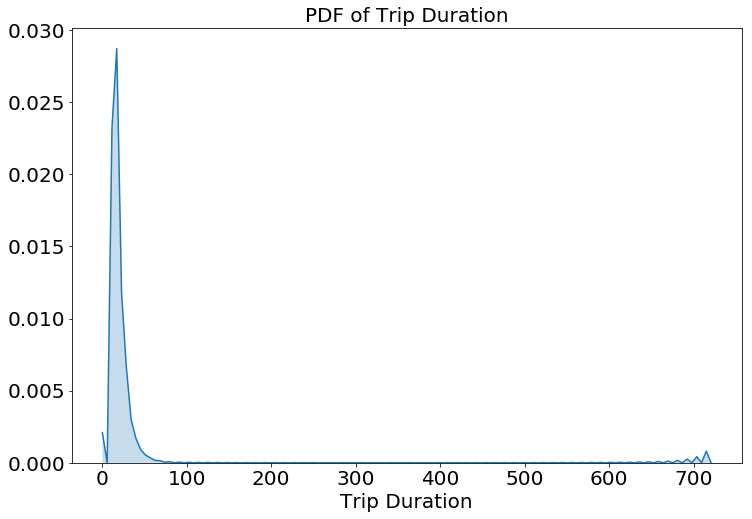

In [24]:
plt.figure(figsize = (12,8))
sns.kdeplot(new_frame_cleaned["trip_duration"].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("PDF of Trip Duration", fontsize = 20)
plt.show()

<b>Observation:</b> Above PDF plot shows that almost all of the trip durations are very less and approximately less than 100, extremely few trip durations are above 100.

## Speed

In [25]:
def changingLabels(num):
    if num < 10**3:
        return num
    elif num>=10**3 and num < 10**6:
        return str(num/10**3)+"k"
    elif num>=10**6 and num < 10**9:
        return str(num/10**6) + "M"
    else:
        return str(num/10**9) + "B"

In [26]:
# fig = plt.figure(figsize = (10,6))
# ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

# ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
# plt.tick_params(labelsize = 20)
# plt.ylabel("Speed(Miles/hr) in Millions", fontsize = 20)
# plt.show()

In [27]:
quantile_speed = new_frame_cleaned.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

<b>Observations:</b> Here, 100th percentile value of a speed is 192 Million miles/hr which is (BIZZARE). Furthermore, 99.9th percentile value of speed is 45.31miles/hr. So, we are removing all the data points where speed is greater than 45.31miles/hr.

In [28]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<45.31)]

#### Box plot of speed after removing outliers and erroneous points.

In [29]:
Average_speed = sum(new_frame_cleaned.speed)/len(new_frame_cleaned.speed)
print("Average Speed of Taxis around NYC = "+str(Average_speed))

Average Speed of Taxis around NYC = 12.452320837813998


In [30]:
print("Speed of Taxis around NYC per 10 minutes = "+str(Average_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC per 10 minutes = 2.075386806302333 per 10 minutes.


### The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

## Trip Distance

In [31]:
# fig = plt.figure(figsize = (10,6))
# ax = sns.boxplot("trip_distance", data = new_frame_cleaned, orient = "v")

# plt.tick_params(labelsize = 20)
# plt.ylabel("Trip Distance(Miles)", fontsize = 20)
# plt.show()

In [32]:
quantile_tripDistance = new_frame_cleaned.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))


In [33]:
# Observation: Here, 99.9th percentile of trip distance is 22.58miles, however, 
# 100th percentile value is 258.9miles, which is very high. So, we are removing all 
# the data points where trip distance is greater than 23miles.
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]

# Observation:Here, 99.9th percentile fare amount of a trip is 86.6. 
# However, 100th percentile of a fare amount is 3Million which is bizzare.
# Therefore, we have removedall the data points where fare amount is more than 
# 99.9th percentile value.
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<86.6)]

# Removing Pickups outside NYC
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]

# Removing Dropoffs outside NYC
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]

# Fraction of points left after removing all the erroneous points and outlier points. 
# Points where pickups and dropoffs are outside of NYC are also removed.
print("Fraction of cleaned points",str(new_frame_cleaned.shape[0]/new_frame.shape[0]))

print("Total number of outliers and erroneous points removed = ",str(new_frame.shape[0] - new_frame_cleaned.shape[0]))


Fraction of cleaned points 0.9680387130396095
Total number of outliers and erroneous points removed =  407474


In [34]:
# m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

# pickups_within_NYC = new_frame_cleaned.sample(n = 500)

# for i,j in pickups_within_NYC.iterrows():
#     folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
# m

<b>Observation:</b> Most of the pickups are concentrated in and around Manhattan district of New York

In [35]:
# m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

# dropoff_within_NYC = new_frame_cleaned.sample(n = 500)

# for i,j in dropoff_within_NYC.iterrows():
#     folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
# m

<b>Observation:</b> Most of the dropoffs are concentrated in and around Manhattan district of New York

# 3. Data Preparation

## Clustering/Segmentation

In [36]:
# 3. Data Preparation
## Clustering/Segmentation

coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [37]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 0.8839277436615148
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 5.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 15.0
Minimum distance between any two clusters = 0.670818012656635
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 23.0
Minimum distance between any two clusters = 0.4616328394251025
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 11.0
Avg. Number clusters outside of vicinity where inte

#### We want the minimum inter cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 30 then this condition is almost meeting. Therefore, we are considering number of clusters to be 30.

In [38]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [39]:
new_frame_cleaned.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,10
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,8
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,7
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,13
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,6


#### Plotting cluster centers

In [40]:
# centerOfRegions = regions.cluster_centers_
# noOfClusters = len(centerOfRegions)
# m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

# for i in range(noOfClusters):
#     folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
# m

#### Plotting Regions in NYC

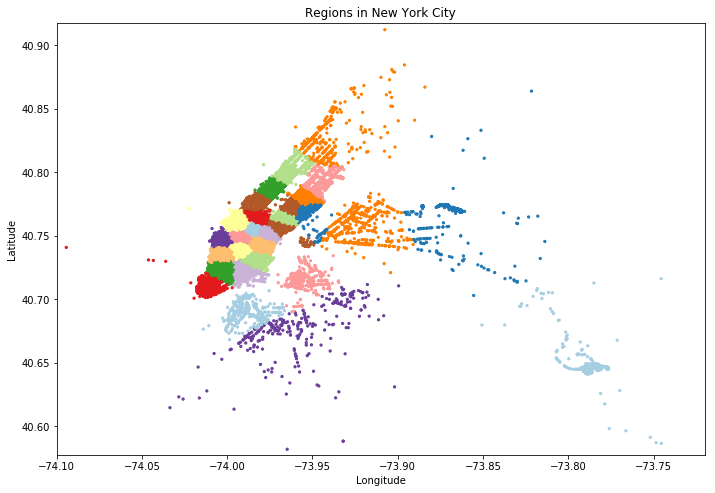

In [41]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned.pickup_longitude.values[:70000], y = new_frame_cleaned.pickup_latitude.values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

## Time Binning

In [42]:
# 1420070400 : 2015-01-01 00:00:00   (Equivalent unix time)
# 1451606400 : 2016-01-01 00:00:00   (Equivalent unix time)

def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe["pickup_time"].values
    unixTime = [1420070400, 1451606400]
    unix_year = unixTime[year-2015]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [43]:
jan_2015_data = pickup_10min_bins(new_frame_cleaned, 1, 2015)

In [44]:
jan_2015_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster,time_bin
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,10,2112
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,8,1401
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,7,1401
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,13,1401
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,6,1401


In [45]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015_data["time_bin"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  4464


In [46]:
jan_2015_timeBin_groupBy = jan_2015_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()

In [47]:
jan_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              -17                  17
               -16                  42
               -15                  52
               -14                  71
               -13                  72

## Data Preparation for Januray 2016

In [48]:
# Up till now we cleaned data and prepared data for the month of Jan 2015.

# now doing the same operations for the month of Jan 2016.

# 1. Get the dataframe which includes only required colums.
# 2. Add trip_duration, speed, unix time stamp of pickup_time.
# 4. Remove the outliers based on trip_duration, speed, trip_distance, total_amount.
# 5. Remove all the points where pickup and dropoff are outside of New York City area.
# 6. Add pickup_cluster to each data point.
# 7. Add time_bin (index of 10min intravel to which that trip belongs to).
# 8. Group by data, based on 'pickup_cluster' and 'time_bin'
startTime = datetime.now()
frame_2016 = dd.read_csv("yellow_tripdata_2016-01.csv")
# frame_2016 = pd.read_csv("yellow_tripdata_2016-01.csv")

print("PREPARATION OF JANUARY 2016 DATA.")
print("-"*35)

print("Number of columns = "+str(len(frame_2016.columns)))
print("-"*35)

new_frame2 = dfWithTripTimes(frame_2016)
print("New Frame for Jan 2016 creation done")
print("-"*35)

new_frame_cleaned2 = new_frame2[(new_frame2.trip_duration>1) & (new_frame2.trip_duration<720)]
print("Trip Duration Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.speed>0) & (new_frame_cleaned2.speed<45.31)]
print("Speed Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.trip_distance>0) & (new_frame_cleaned2.trip_distance<23)]
print("Trip Distance Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.total_amount>0) & (new_frame_cleaned2.total_amount<86.6)]
print("Total Amount Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.pickup_latitude >= 40.5774) & (new_frame_cleaned2.pickup_latitude <= 40.9176)) & ((new_frame_cleaned2.pickup_longitude >= -74.15) & (new_frame_cleaned2.pickup_longitude <= -73.7004)))]
print("Pickups outside of NYC are removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.dropoff_latitude >= 40.5774) & (new_frame_cleaned2.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned2.dropoff_longitude >= -74.15) & (new_frame_cleaned2.dropoff_longitude <= -73.7004)))]
print("Dropoffs outside of NYC are removed")
print("-"*35)

new_frame_cleaned2["pickup_cluster"] = regions.predict(new_frame_cleaned2[["pickup_latitude", "pickup_longitude"]])
print("Pickup Clusters are assigned")
print("-"*35)

jan_2016_data = pickup_10min_bins(new_frame_cleaned2, 1, 2016)
print("Pickup time bins are assigned")
print("-"*35)

jan_2016_timeBin_groupBy = jan_2016_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()
print("Pickup cluster and time bins are grouped.")
print("-"*35)

print("Done...")
print("-"*35)

print("Fraction of Total data left = "+str(new_frame_cleaned2.shape[0]/new_frame2.shape[0]))
print("Total Number of outliers removed = "+str(new_frame2.shape[0] - new_frame_cleaned2.shape[0]))
print("-"*35)

print("Total Time taken for execution of Jan 2016 data = "+str(datetime.now() - startTime))
print("-"*35)

PREPARATION OF JANUARY 2016 DATA.
-----------------------------------
Number of columns = 19
-----------------------------------
Time taken for creation of dataframe is 0:04:05.274906
New Frame for Jan 2016 creation done
-----------------------------------
Trip Duration Outliers removed
-----------------------------------
Speed Outliers removed
-----------------------------------
Trip Distance Outliers removed
-----------------------------------
Total Amount Outliers removed
-----------------------------------
Pickups outside of NYC are removed
-----------------------------------
Dropoffs outside of NYC are removed
-----------------------------------
Pickup Clusters are assigned
-----------------------------------
Pickup time bins are assigned
-----------------------------------
Pickup cluster and time bins are grouped.
-----------------------------------
Done...
-----------------------------------
Fraction of Total data left = 0.9702401919966318
Total Number of outliers removed = 3245

In [49]:
jan_2016_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster,time_bin
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,1.451596e+09,17.902703,16,-18
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,1.451596e+09,16.710280,20,-18
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,1.451596e+09,6.050420,16,-17
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,1.451596e+09,32.142857,12,-17
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,1.451596e+09,17.351351,8,-17


In [50]:
jan_2016_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              -17                  15
               -16                  31
               -15                  44
               -14                  61
               -13                  66

In [51]:
jan_2015_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster,time_bin
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,10,2112
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,8,1401
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,7,1401
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,13,1401
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,6,1401


In [52]:
jan_2015_timeBin_groupBy.head()
# jan_2015_timeBin_groupBy["trip_distance"].values

trip_distance
pickup_cluster time_bin               
0              -17                  17
               -16                  42
               -15                  52
               -14                  71
               -13                  72

## Smoothing

In [53]:
# Gets the unique time bins where pickup values are present for each region.

# for each cluster region we will collect all the indices of 10min intervals in which pickups happened.
# we got an observation that there are some time bins that doesn't have any pickups.

def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values
#this function is returning the indices of all the unique time_bins where there is a pickup for all the 30 clusters.

In [54]:
#now for Jan-2015, we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_Jan_2015 = getUniqueBinsWithPickups(jan_2015_data)
for i in range(30):             #we have total 30 clusters
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_Jan_2015[i]))))
    print("-"*90)
#there are total 4464 time bins in Jan - 2015.
#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

For cluster ID 0, total number of time bins with no pickup in this clutser region is 58
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 34
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 117
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 42
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 31
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 36
----------------

There are two ways to fill up these values:

* Fill the missing value with 0's.

In [55]:
# Fill the missing value with 0's.
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4464):    #there are total 4464 time bins in both Jan-2015 & Feb-2016.
            if t in correspondingTimeBin[c]:   #if a time bin is present in "correspondingTimeBin" in cluster 'c', 
            #then it means there is a pickup, in this case, we are simply adding number of pickups, else we are adding 0.
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
#above function performs the operation in this way: if in any cluster if there is no pickup in any of the 4464 time bins, then 
#it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.

In [56]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4464 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4464 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4464 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

# when we multiply any integer with "1.0", then it will be converted into float.

In [57]:
jan_2015_fillZero = fillMissingWithZero(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)
# here in jan_2015_timeBin_groupBy dataframe the "trip_distance" represents the number of pickups that are happened.
jan_2015_fillSmooth = smoothing(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)

#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

In [58]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [59]:
print("Number of values filled with zero in zero fill data= "+str(countZeros(jan_2015_fillZero)))

Number of values filled with zero in zero fill data= 2608


In [60]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(jan_2015_fillSmooth)))

Sanity check for number of zeros in smoothed data = 0


There are total 30 clusters. Each cluster has 4464 time bins. After smoothing or fillWithZero, each of 4464 time bin has a pickup. So, there should be a total of <b>4464*30 = 133920</b> pickup values present for the month of January 2015. Let's Check, is it correct?

In [61]:
print("Total number of pickup values = "+str(len(jan_2015_fillZero)))
print("Total number of pickup values = "+str(len(jan_2015_fillSmooth)))

Total number of pickup values = 133920
Total number of pickup values = 133920


#### Above plot is a plot of all the pickup values for cluster 26th. It shows that all the zero filled are separated by avg filled values. The minimum average filled value is 1.

In [62]:
unique_binswithPickup_Jan_2016 = getUniqueBinsWithPickups(jan_2016_data)

In [63]:
# Jan-2015 data is smoothed, Jan-2016 data missing values are filled with zero
jan_2016_fillZero = fillMissingWithZero(jan_2016_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2016)

In [64]:
regionWisePickup_Jan_2016 = []
for i in range(30):
    regionWisePickup_Jan_2016.append(jan_2016_fillZero[4464*i:((4464*i)+4464)])
#"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in Jan 2016, hence, each sub-list is of size 4464.

In [65]:
print(len(regionWisePickup_Jan_2016))
print(len(regionWisePickup_Jan_2016[0]))

30
4464


In [66]:
def find_missing_timeBins(IDs):
    missing = []
    for i in range(len(unique_binswithPickup_Jan_2015[IDs]) - 1):
        j = unique_binswithPickup_Jan_2015[IDs][i]
        k = unique_binswithPickup_Jan_2015[IDs][i+1]
        if (k-j) > 1:
            for l in range(j+1, k):
                missing.append(l)
    return missing

# 4. Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan-2016 for which we are using multiple models with two variations. 
1. Using Ratios of the 2016 data to the 2015 data i.e $R_{t} = P^{2016}_{t} / P^{2015}_{t}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Preparing dataframe with $x_i$ as Jan- 2015 pickups and $y_i$ as Jan-2016 Pickups, with ratios as $Pickup^{2016} / Pickup^{2015}.$

In [67]:
Ratios_DF = pd.DataFrame()
Ratios_DF["Given"] = jan_2015_fillSmooth
Ratios_DF["Prediction"] = jan_2016_fillZero
Ratios_DF["Ratio"] = Ratios_DF["Prediction"]*1.0/Ratios_DF["Given"]*1.0

In [68]:
Ratios_DF.head()

,Given,Prediction,Ratio
0,17,15,0.882353
1,42,31,0.738095
2,52,44,0.846154
3,71,61,0.859155
4,72,66,0.916667


In [69]:
Ratios_DF.shape

(133920, 3)

In [70]:
print("Total Number of zeros in Ratio column = "+str(Ratios_DF["Ratio"].value_counts()[0]))

Total Number of zeros in Ratio column = 4050


In [71]:
print("Total Number of zeros in Prediction column = "+str(Ratios_DF["Prediction"].value_counts()[0]))

Total Number of zeros in Prediction column = 4050


## Simple Weighted Moving Average
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values: $R_t = (N*R_{t-1} + N-1*R_{t-2} + N-2*R_{T-3} + ...) / N*(N+1)/2$

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 4 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ R_{t} = ( 4*R_{t-1} + 3*R_{t-2} + 2*R_{t-3} + 1*R_{t-4})/10$

Weighted Moving Averages using Previous 2016 Values - $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [72]:
def weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow(int(predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumPickups = sumPickups + j*(ratios["Prediction"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_pickup = sumPickups/sumOfWeights
        else:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumPickups += j*(ratios["Prediction"].values)[j-1]
                sumOfWeights += j
            predicted_pickup = sumPickups/sumOfWeights
    
    ratios["Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ P_t = ( 2*P_{t-1} + 1*P_{t-2})/2$

Here, above, alpha is a hyper-parameter which needs to be tuned manually. It is found that alpha = 0.5 gives lowest MAPE value.

In [73]:
r4, mape4, mse4 = weighted_moving_average_predictions(Ratios_DF)

In [74]:
error_table_baseline = pd.DataFrame(columns = ["Model", "MAPE(%)", "MSE"])

error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100, mse4]], columns = ["Model", "MAPE(%)", "MSE"]))

error_table_baseline.reset_index(drop = True, inplace = True)

In [75]:
error_table_baseline.style.highlight_min(axis=0)

,Model,MAPE(%),MSE
0,Weighted Moving Average Predictions,13.2454,297.322


<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

<b>From the above error table it is inferred that the best forecasting model for our prediction would be:-</b>
$P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$ i.e Weighted Moving Averages Predictions using 2016 Values.

# 5. Regression Models

### Preparing Data

Preparing data to be split into train and test, The below code prepares data in cumulative form which will be later split into
test and train

There are total 30 clusters and for the month of January-2016 and there are total 4464 time bins. 
For each cluster region there are 4464 time bins and so, for 30 clusters there will be 4464*30 pickup values because after 
smoothing each time bin has pickup.
We will have a total of 4464*30 = 133920 pickup values.

In [76]:
# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# TruePickups varaible
# it is list of lists
# It will be used as true labels/ground truth. Now since we are taking previous 5 pickups as a training data for predicting
# next pickup(here next pickup will be a true/ground truth pickup), so "TruePickups" will not contain first five pickups of each 
# cluster. It will contain number of pickups 4459 for each cluster. 
TruePickups = []

# lat will contain 4464-5=4459 times latitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lat = []

# lon will contain 4464-5=4459 times longitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
day_of_week = []


# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists

# feat is a numbpy array, of shape (133770, 5). {4459*30 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []


centerOfRegions = regions.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4459) 
    lon.append([centerOfRegions[i][1]]*4459)
    #1 January 2016 is a Friday so we start our day from 5: "(int(j/144))%7+5"
    # Our prediction starts from 5th 10min interval since we need to have number of pickups that are happened in last 5 pickup bins.
    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4464)])
    #"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
    #corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
    #in Jan 2016, hence, each sub-list is of size 4464.
    #"regionWisePickup_Jan_2016" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
    #Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively
    feat = np.vstack((feat, [regionWisePickup_Jan_2016[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_Jan_2016[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_Jan_2016[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
feat = feat[1:]

In [77]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4459*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [78]:
feat

array([[15, 31, 44, 61, 66],
       [31, 44, 61, 66, 70],
       [44, 61, 66, 70, 91],
       ...,
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

### Adding Predictions of Weighted Moving Average Predictions as a feature in our data

Getting the predictions of weighted moving averages to be used as a feature in cumulative form.

Upto now we computed 8 features for every data point that starts from 50th min of the day.
1. cluster center latitude
2. cluster center longitude
3. day of the week 
4. f_t_1: number of pickups that are happened previous t-1st 10min interval
5. f_t_2: number of pickups that are happened previous t-2nd 10min interval
6. f_t_3: number of pickups that are happened previous t-3rd 10min interval
7. f_t_4: number of pickups that are happened previous t-4th 10min interval
8. f_t_5: number of pickups that are happened previous t-5th 10min interval

From the baseline models we said that the weighted moving avarage predictions gives us the best error.
We will try to add the same weighted moving avarage predictions at time t as a feature to our data.<br>
Weighted Moving Average -> $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [79]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 4464 values
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later

window_size = 2
for i in range(30):
    for j in range(4464):
        if j == 0:
            predicted_value = regionWisePickup_Jan_2016[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_Jan_2016[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_Jan_2016[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [80]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*30

True

### Adding Top 5 Frequencies and Amplitudes of Fourier Transform as features

In [81]:
amplitude_lists = []
frequency_lists = []
for i in range(30):
    ampli  = np.abs(np.fft.fft(regionWisePickup_Jan_2016[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        #it will return an array of indices for which corresponding amplitude values are sorted in reverse order.
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values) 

<b>Now we have built our all the features. We have finally now following 19 features in our data:</b>
1. <b>f_t_1:</b> Number of pickups that are happened previous t-1st 10min interval
2. <b>f_t_2:</b> Number of pickups that are happened previous t-2nd 10min interval
3. <b>f_t_3:</b> Number of pickups that are happened previous t-3rd 10min interval
4. <b>f_t_4:</b> Number of pickups that are happened previous t-4th 10min interval
5. <b>f_t_5:</b> Number of pickups that are happened previous t-5th 10min interval 
6. <b>Freq1:</b> Fourier Frequency corresponding to 1st highest amplitude
7. <b>Freq2:</b> Fourier Frequency corresponding to 2nd highest amplitude
8. <b>Freq3:</b> Fourier Frequency corresponding to 3rd highest amplitude
9. <b>Freq4:</b> Fourier Frequency corresponding to 4th highest amplitude
10. <b>Freq5:</b> Fourier Frequency corresponding to 5th highest amplitude
11. <b>Amp1:</b>  Amplitude corresponding to 1st highest fourier transformed wave.
12. <b>Amp2:</b>  Amplitude corresponding to 2nd highest fourier transformed wave.
13. <b>Amp3:</b>  Amplitude corresponding to 3rd highest fourier transformed wave.
14. <b>Amp4:</b>  Amplitude corresponding to 4th highest fourier transformed wave.
15. <b>Amp5:</b>  Amplitude corresponding to 5th highest fourier transformed wave.
16. <b>Latitude:</b> Latitude of Cluster center.
17. <b>Longitude:</b> Longitude of Cluster Center.
18. <b>WeekDay:</b> Day of week of pickup.
19. <b>WeightedAvg:</b>: Weighted Moving Average Prediction values.

## Data Preparation for regression models
Before we start predictions using the tree based regression models we take Jan 2016 pickup data and split it such that for every region we have 80% data in train and 20% in test, ordered date-wise for every region.

In [82]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [83]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [84]:
train_previousFive_pickups  = [feat[i*4459:(4459*i+3567)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [85]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [86]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [87]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [88]:
#taking 80% data as train data from each cluster
train_lat = [i[:3567] for i in lat]
train_lon = [i[:3567] for i in lon]
train_weekDay = [i[:3567] for i in day_of_week]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3567] for i in TruePickups]

In [89]:
#taking 20% data as test data from each cluster
test_lat = [i[3567:] for i in lat]
test_lon = [i[3567:] for i in lon]
test_weekDay = [i[3567:] for i in day_of_week]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3567:] for i in TruePickups]

In [90]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [91]:
#stacking pickups,frequencies and amplitudes horizontally.


train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [92]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [93]:
# converting lists of lists into single list i.e flatten

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [94]:
#train dataframe
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [95]:
#test dataframe
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [96]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (107010, 19)
Shape of test data = (26760, 19)


In [97]:
Train_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,15.0,31.0,44.0,61.0,66.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,5,64
1,31.0,44.0,61.0,66.0,70.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,5,68
2,44.0,61.0,66.0,70.0,91.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,5,84
3,61.0,66.0,70.0,91.0,88.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,5,89
4,66.0,70.0,91.0,88.0,89.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,5,88


In [98]:
Test_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,31.0,30.0,34.0,32.0,26.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,1,28
1,30.0,34.0,32.0,26.0,26.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,1,26
2,34.0,32.0,26.0,26.0,31.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,1,29
3,32.0,26.0,26.0,31.0,19.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,1,23
4,26.0,26.0,31.0,19.0,13.0,0.013916,0.012939,0.020752,0.020996,0.027832,14216.8593,10549.771686,8067.542692,6840.878674,6739.756276,40.689231,-73.987923,1,15


## Linear Regression

In [99]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## XGBoost Regressor

In [100]:
def xgboost_reg(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[40, 80, 150, 600]}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    
    #applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [101]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)

trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgboost_reg(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)

[17:50:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# 6. Model Comparison

In [102]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))

error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)

In [103]:
error_table_regressions

,Model,TrainMAPE(%),TrainMSE,TestMAPE(%),TestMSE
0,Linear Regression,13.437974,315.879649,15.517448,283.877262
1,XGBoost Regressor,13.070901,277.297984,13.089883,219.382301


### From the above result we have following observations:
* <b>1. The difference between train error and test error of random forest regressor is high, which clearly shows that random forest regressor is overfitting. Therefore, we are discarding random forest regressor.</b>
* <b>2. The best model with lowest train and test error is XGBoost Regressor.</b>

In [104]:
Final_Table = pd.DataFrame(columns = ["Model", "Mean_Absolute_Per_Error(%)"])

Final_Table = Final_Table.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))

Final_Table = Final_Table.append(pd.DataFrame([["Linear Regression", testMAPE_lr*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))

Final_Table = Final_Table.append(pd.DataFrame([["XGBoost Regressor", testMAPE_xgb*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))

Final_Table.reset_index(drop = True, inplace = True)

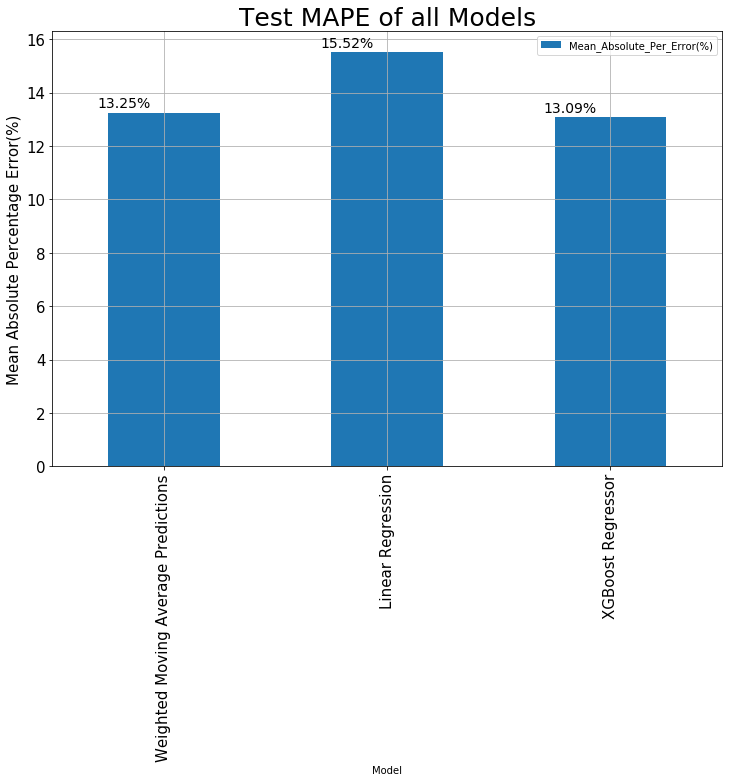

In [105]:
ax = Final_Table.plot(x = "Model", kind = "bar", figsize = (12, 8), grid = True, fontsize = 15)
ax.set_title("Test MAPE of all Models", fontsize = 25)
ax.set_ylabel("Mean Absolute Percentage Error(%)", fontsize = 15)

for i in ax.patches:   #ax.patches is an array which gives x position, y position, width of a bar graphs.
    ax.text(i.get_x()-.05, i.get_height()+0.19, str(round(i.get_height(), 2))+'%', fontsize=14, color='black')
#     ax.text(x, y, annotate_text, font_size, color)
plt.show()

In [106]:
Final_Table.style.highlight_min(axis=0)

,Model,Mean_Absolute_Per_Error(%)
0,Weighted Moving Average Predictions,13.2454
1,Linear Regression,15.5174
2,XGBoost Regressor,13.0899


# So, far our best model is XGBoost Regressor with Test MAPE: 11.57%